In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# sagemaker libraries
import boto3
import sagemaker

# Data Modeling

Now, the data is ready to be fed into a machine learning model!

Each data point has 57 features, which means the data is 57-dimensional. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters.

> Instead, we really want to find the features that help to separate and group data. We want to find features that cause the **most variance** in the dataset!

So, before I cluster this data, I’ll want to take a dimensionality reduction step. My aim will be to form a smaller set of features that will better help to separate our data. The technique I’ll use is called PCA or **principal component analysis**

### Loading cleaned data

In [3]:
cleaned_customers = pd.read_pickle('cleaned_customers.pkl')

In [4]:
cleaned_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Data columns (total 57 columns):
CJT_GESAMTTYP                191652 non-null float64
CJT_KATALOGNUTZER            191652 non-null float64
CJT_TYP_1                    191652 non-null float64
CJT_TYP_2                    191652 non-null float64
CJT_TYP_3                    191652 non-null float64
CJT_TYP_4                    191652 non-null float64
CJT_TYP_5                    191652 non-null float64
CJT_TYP_6                    191652 non-null float64
D19_BANKEN_DATUM             191652 non-null float64
D19_BANKEN_OFFLINE_DATUM     191652 non-null float64
D19_BANKEN_ONLINE_DATUM      191652 non-null float64
D19_GESAMT_DATUM             191652 non-null float64
D19_GESAMT_OFFLINE_DATUM     191652 non-null float64
D19_GESAMT_ONLINE_DATUM      191652 non-null float64
D19_KONSUMTYP_MAX            191652 non-null float64
D19_TELKO_DATUM              191652 non-null float64
D19_TELKO_OFFLINE_DATUM      191652 non-n

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in SageMaker model for PCA.

### Roles and Buckets

> To create a model, you'll first need to specify an IAM role, and to save the model attributes, you'll need to store them in an S3 bucket.

The `get_execution_role` function retrieves the IAM role you created at the time you created your notebook instance. Roles are essentially used to manage permissions and you can read more about that [in this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html). For now, know that we have a FullAccess notebook, which allowed us to access and download the census data stored in S3.

You must specify a bucket name for an S3 bucket in your account where you want SageMaker model parameters to be stored. Note that the bucket must be in the same region as this notebook. You can get a default S3 bucket, which automatically creates a bucket for you and in your region, by storing the current SageMaker session and calling `session.default_bucket()`.

In [5]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::635229580099:role/service-role/AmazonSageMaker-ExecutionRole-20190707T015938


In [6]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-2-635229580099



# Define a PCA Model 

## Define a PCA Model

To create a PCA model, I'll use the built-in SageMaker resource. A SageMaker estimator requires a number of parameters to be specified; these define the type of training instance to use and the model hyperparameters. A PCA model requires the following constructor arguments:

* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.

Documentation on the PCA model can be found [here](http://sagemaker.readthedocs.io/en/latest/pca.html).

Below, I first specify where to save the model training data, the `output_path`.

In [7]:
# define location to store model artifacts
prefix = 'Arvato'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-2-635229580099/Arvato/


In [8]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=56

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The *record_set* function in the SageMaker PCA model converts a numpy array into a **RecordSet** format that is the required format for the training input data. This is a requirement for _all_ of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.

In [9]:
# convert df to np array
train_data_np = cleaned_customers.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

## Train the model

Call the fit function on the PCA model, passing in our formatted, training data. This spins up a training instance to perform the training job.

Note that it takes the longest to launch the specified training instance; the fitting itself doesn't take much time.

In [10]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2019-07-09 10:22:56 Starting - Starting the training job...
2019-07-09 10:22:57 Starting - Launching requested ML instances......
2019-07-09 10:24:00 Starting - Preparing the instances for training...
2019-07-09 10:24:52 Downloading - Downloading input data...
2019-07-09 10:25:23 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[07/09/2019 10:25:38 INFO 140114863286080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[07/09/2019 10:25:38 INFO 140114863286080] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'57', u'mini_batch_size': u'500', u'num_components': u'56'}
[07/09/2019 10:25:38 INFO 14011486328608

## Accessing the PCA Model Attributes

After the model is trained, we can access the underlying model parameters.

### Unzip the Model Details

Now that the training job is complete, you can find the job under **Jobs** in the **Training**  subsection  in the Amazon SageMaker console. You can find the job name listed in the training jobs. Use that job name in the following code to specify which model to examine.

Model artifacts are stored in S3 as a TAR file; a compressed file in the output path we specified + 'output/model.tar.gz'. The artifacts stored here can be used to deploy a trained model.

In [11]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name = pca_SM.latest_training_job.name

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Arvato/pca-2019-07-09-10-22-56-522/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

You can take a look at the MXNet [documentation, here](https://aws.amazon.com/mxnet/).

In [12]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[ 12.538515  13.555766  18.653543  21.06087   22.263292  23.332775
  26.808784  27.406322  27.684015  28.979084  31.871115  32.576374
  32.76236   35.573666  38.671     39.986965  41.8118    42.258015
  46.739956  48.929134  49.734097  51.223675  52.557476  52.63508
  56.38463   58.66021   59.295483  60.72621   62.441795  63.544086
  64.443344  64.54541   67.78962   72.11028   75.23365   75.8276
  78.53544   81.27167   84.13096   85.64351   87.69886   90.1165
  91.75419   93.91444   99.01201  100.20361  114.12453  120.09266
 132.24637  134.56863  137.52538  174.52731  209.7691   289.73987
 314.9281   529.83527 ]
<NDArray 56 @cpu(0)>, 'v': 
[[ 3.32485157e-04 -3.87063692e-03 -2.07414129e-03 ... -1.06544815e-01
   9.10342038e-02 -1.31977275e-01]
 [-2.01506831e-04 -1.30896457e-02 -1.38888205e-03 ...  2.30371609e-01
   4.87687849e-02 -6.76662773e-02]
 [ 1.25889666e-03  4.67337156e-03 -2.67995317e-02 ... -1.34497523e-01
   2.81283706e-02 -1.76066503e-01]
 ...
 [-1.64344106e-04  7.4809

## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.

In [13]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

## Data Variance

Our current PCA model creates 33 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much **data variance** the components capture. For our original, high-dimensional data, 34 features captured 100% of our data variance. If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

### Tradeoff: dimensionality vs. data variance

As an illustrative example, say we have original data in three dimensions. So, three dimensions capture 100% of our data variance; these dimensions cover the entire spread of our data. The below images are taken from the PhD thesis,  [“Approaches to analyse and interpret biological profile data”](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/index/index/docId/696) by Matthias Scholz, (2006, University of Potsdam, Germany).

Now, you may also note that most of this data seems related; it falls close to a 2D plane, and just by looking at the spread of the data, we  can visualize that the original, three dimensions have some correlation. So, we can instead choose to create two new dimensions, made up of linear combinations of the original, three dimensions. These dimensions are represented by the two axes/lines, centered in the data. 

If we project this in a new, 2D space, we can see that we still capture most of the original data variance using *just* two dimensions. There is a tradeoff between the amount of variance we can capture and the number of component-dimensions we use to represent our data.

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [14]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

             0
51  174.527313
52  209.769104
53  289.739868
54  314.928101
55  529.835266


In [15]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


### Test Cell

Test out your own code by seeing how it responds to different inputs; does it return a reasonable value for the single, top component? What about for the top 5 components?

In [16]:
# test cell
n_top_components = 12 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8173727


As an example, you should see that the top principal component accounts for about 32% of our data variance! Next, you may be wondering what makes up this (and other components); what linear combination of features make these components so influential in describing the spread of our data?

Below, let's take a look at our original features and use that as a reference.

In [17]:
# features
features_list = cleaned_customers.columns.values
print('Features: \n', features_list)

Features: 
 ['CJT_GESAMTTYP' 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3'
 'CJT_TYP_4' 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_DATUM'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM' 'D19_KONSUMTYP_MAX'
 'D19_TELKO_DATUM' 'D19_TELKO_OFFLINE_DATUM' 'D19_TELKO_ONLINE_DATUM'
 'D19_VERSAND_DATUM' 'D19_VERSAND_OFFLINE_DATUM'
 'D19_VERSAND_ONLINE_DATUM' 'D19_VERSI_DATUM' 'D19_VERSI_OFFLINE_DATUM'
 'D19_VERSI_ONLINE_DATUM' 'FINANZ_ANLEGER' 'FINANZ_HAUSBAUER'
 'FINANZ_MINIMALIST' 'FINANZ_SPARER' 'FINANZ_UNAUFFAELLIGER'
 'FINANZ_VORSORGER' 'FINANZTYP' 'GFK_URLAUBERTYP' 'HH_EINKOMMEN_SCORE'
 'KOMBIALTER' 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'ONLINE_AFFINITAET'
 'RETOURTYP_BK_S' 'RT_KEIN_ANREIZ' 'RT_SCHNAEPPCHEN' 'SEMIO_DOM'
 'SEMIO_ERL' 'SEMIO_FAM' 'SEMIO_KAEM' 'SEMIO_KRIT' 'SEMIO_KULT'
 'SEMIO_LUST' 'SEMIO_MAT' 'SEMIO_PFLICHT' 'SEMIO_RAT' 'SEMIO_REL'
 'SEMIO_SOZ' 'SEMIO_TRADV' 'SEMIO_VERT' 'ZABEOTYP' 'ANREDE_KZ'
 

In [18]:
len(cleaned_customers.columns)

57

## Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [19]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

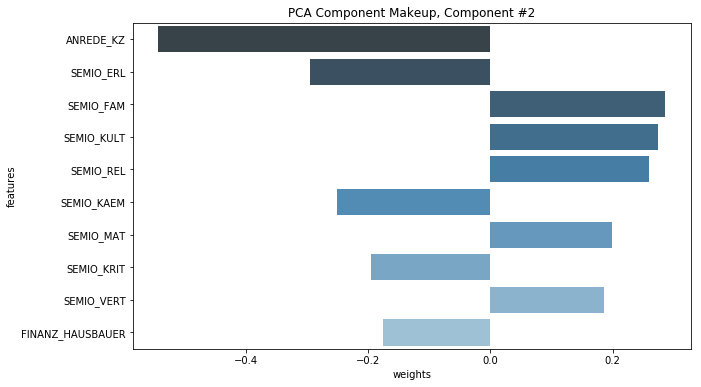

In [20]:
# display makeup of first component
num=2
display_component(v, cleaned_customers.columns.values, component_num=num, n_weights=10)

# Deploying the PCA Model

We can now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, we'll actually want to pass our training data into the deployed endpoint to create principal components for each data point. 

Run the cell below to deploy/host this model on an instance_type that we specify.

In [21]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

---------------------------------------------------------------------------------------!CPU times: user 532 ms, sys: 41.2 ms, total: 573 ms
Wall time: 7min 19s


We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [22]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-east-2.amazonaws.com/endpoints/pca-2019-07-09-10-22-56-522/invocations".

In [ ]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

### Create a transformed DataFrame

In [35]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    counties_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        counties_transformed=counties_transformed.append([list(components)])

    # index by county, just like counties_scaled
    counties_transformed.index=counties_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    counties_transformed = counties_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return counties_transformed.iloc[:, ::-1]

Now we can create a dataset where each county is described by the top n principle components that we analyzed earlier. Each of these components is a linear combination of the original feature space. We can interpret each of these components by analyzing the makeup of the component, shown previously.

In [ ]:
# specify top n
top_n = 7

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
counties_transformed.columns=PCA_list 

# print result
counties_transformed.head()

### Delete the Endpoint!

Now that we've deployed the model and created our new, transformed training data, we no longer need the PCA endpoint.

As a clean up step, you should always delete your endpoints after you are done using them (and if you do not plan to deploy them to a website, for example).